In [1]:
from quests_data import *

import random
import tqdm
import itertools
from ase import Atoms
from ase.io import read
from quests.tools.plotting import savefig
from scipy.optimize import curve_fit
from scipy import stats

## Entropy curves for dataset sizes

In [2]:
nenvs = pd.Series({
    "aspirin": 9 + 8 + 4,
    "azobenzene": 14 + 15 + 3,
    "benzene": 6 + 6,
    "malonaldehyde": 3 + 4 + 2,
    "naphthalene": 10 + 8,
    "ethanol": 2 + 6 + 1,
    "paracetamol": 8 + 9 + 1 + 2,
    "salicylic": 7 + 6 + 3,
    "toluene": 7 + 8,
    "uracil": 4 + 4 + 2 + 2, 
})

## Loading the precomputed entropies

In [3]:
DATA_PATH = "../data/02-rMD17/entropies/"
files = sorted(os.listdir(DATA_PATH))

all_results = []
for _file in files:
    name = _file.split(".")[0]
    path = os.path.join(DATA_PATH, _file)
    with open(path, "r") as f:
        data = json.load(f)
    
    for d in data:
        all_results.append({**d, "name": name})
        
df = pd.DataFrame(all_results)
df["logn"] = np.log(df["n_samples"].values * nenvs.loc[df["name"]].values)

In [4]:
H = df.pivot(index="n_samples", columns="name", values="H")
logn = df.pivot(index="n_samples", columns="name", values="logn")

H.to_csv("entropies.csv")

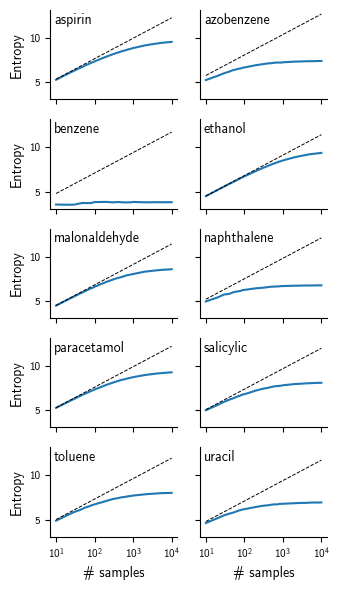

In [5]:
fig, ax_fig = plt.subplots(5, 2, figsize=(3.5, 6), sharex=True, sharey=True)

for ax, name in zip(ax_fig.reshape(-1), H.columns):    
    ax.plot(H.index, H[name])
    ax.plot(logn.index, logn[name], "k--", linewidth=0.7)
#     ax.plot([1e3, 1e3], [H.loc[1000, name], logn.loc[1000, name]], "r--", linewidth=0.7)
    
    ax.annotate(name, (0.03, 0.97), xycoords="axes fraction", va="top", fontsize=10)
    ax.set_xscale("log")

for ax in ax_fig[:, 0]:
    ax.set_ylabel("Entropy")

for ax in ax_fig[-1, :]:
    ax.set_xlabel("# samples")
    ax.set_xticks([1e1, 1e2, 1e3, 1e4])

fig.tight_layout()
# savefig(fig, "03-rmd17-all-entropies.pdf")
plt.show()

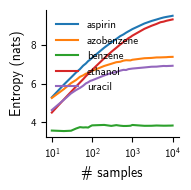

In [6]:
fig, ax = plt.subplots(figsize=(2, 2))

for name in ["aspirin", "azobenzene", "benzene", "ethanol", "uracil"]:
    ax.plot(H.index, H[name], label=name)
#     ax.plot(logn.index, logn[name], "k--", linewidth=0.7)

ax.set_ylabel("Entropy (nats)")
ax.set_xlabel("# samples")
ax.set_xscale("log")
ax.legend(frameon=False)
ax.set_xticks([1e1, 1e2, 1e3, 1e4])

fig.tight_layout()

# savefig(fig, "03-rmd17-entropies.pdf")
plt.show()

## Finding the asymptotes

In [7]:
def fn(x, a, b, c):
    z = np.log(x)
    return a - b * np.exp(-c * z ** 2)

In [8]:
mol_params = {}
for mol, h in H.T.iterrows():
    h = h.iloc[3:-3]
    params, _ = curve_fit(fn, h.index, h.values, p0=[h.values[-1], 2, 0.1])
    mol_params[mol] = params

In [9]:
estH = pd.DataFrame([
    {
        "name": mol,
        "entropy": fn(n, *params),
        "n_samples": n
    }
    for mol, params in mol_params.items()
    for n in H.index
])

estH = estH.pivot(index="n_samples", columns="name", values="entropy")

In [10]:
max_H = pd.Series({
    mol: fn(1e12, *params)
    for mol, params in mol_params.items()
})

## Estimating the information gap

In [11]:
gap = (max_H - H)
est_gap = (max_H - estH)

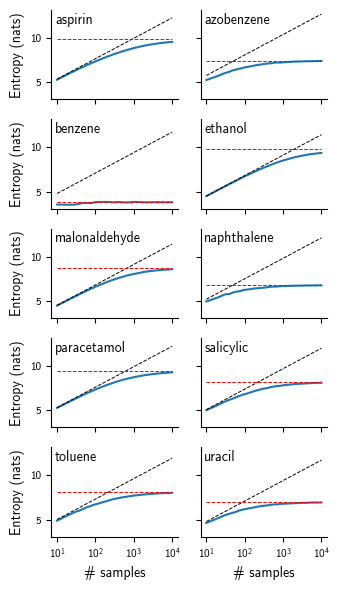

In [12]:
fig, ax_fig = plt.subplots(5, 2, figsize=(3.5, 6), sharex=True, sharey=True)

for ax, name in zip(ax_fig.reshape(-1), H.columns):    
    ax.plot(H.index, H[name])
    ax.plot(logn.index, logn[name], "k--", linewidth=0.7)
    ax.plot([1e1, 1e4], [max_H.loc[name], max_H.loc[name]], "r--", linewidth=0.7)
    
    ax.annotate(name, (0.03, 0.97), xycoords="axes fraction", va="top", fontsize=10)
    ax.set_xscale("log")

for ax in ax_fig[:, 0]:
    ax.set_ylabel("Entropy (nats)")

for ax in ax_fig[-1, :]:
    ax.set_xlabel("# samples")
    ax.set_xticks([1e1, 1e2, 1e3, 1e4])

fig.tight_layout()
# savefig(fig, "04-rmd17-all-entropies.pdf")
plt.show()

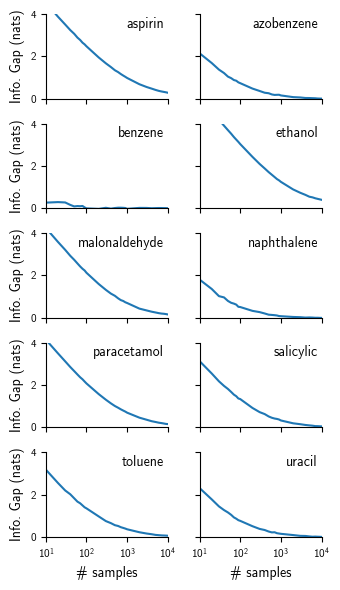

In [13]:
fig, ax_fig = plt.subplots(5, 2, figsize=(3.5, 6), sharex=True, sharey=True)

for ax, name in zip(ax_fig.reshape(-1), H.columns):    
    ax.plot(gap.index, gap[name])
#     ax.plot([1e3, 1e3], [0, gap.loc[1000, name]], "r--", linewidth=0.7)
    
    ax.annotate(name, (0.97, 0.97), xycoords="axes fraction", va="top", ha="right", fontsize=10)
    ax.set_xscale("log")
    ax.set_xlim(1e1, 1e4)
    ax.set_ylim(0, 4)
    ax.set_xticks([1e1, 1e2, 1e3, 1e4])

for ax in ax_fig[:, 0]:
    ax.set_ylabel("Info. Gap (nats)")

for ax in ax_fig[-1, :]:
    ax.set_xlabel("# samples")

fig.tight_layout()
# savefig(fig, "04-rmd17-info-gap.pdf")
plt.show()

## Analyzing the errors

Uses the data above and the errors reported in the original MACE paper.

In [14]:
mols = pd.read_csv("../data/02-rMD17/mols-summary.csv", index_col=0)

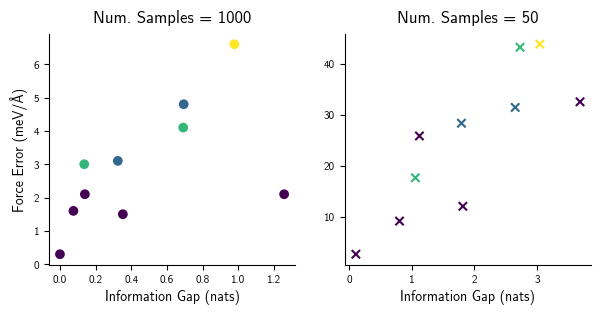

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

sc = axs[0].scatter(mols["gap_1000"], mols["error_1000"], c=mols["rotbonds"])
sc = axs[1].scatter(mols["gap_50"], mols["error_50"], c=mols["rotbonds"], marker="x")

# cbar = fig.colorbar(sc)
# cbar.set_label("# Rot. Bonds")
# cbar.set_ticks([0, 1, 2, 3])

axs[0].set_ylabel("Force Error (meV/Å)")
axs[0].set_xlabel("Information Gap (nats)")
axs[1].set_xlabel("Information Gap (nats)")

axs[0].set_title("Num. Samples = 1000")
axs[1].set_title("Num. Samples = 50")

# savefig(fig, "04-rmd17-const.pdf")
plt.show()

In [16]:
_x = np.concatenate([mols["gap_1000"].values, mols["gap_50"].values])
_y = np.concatenate([mols["error_1000"].values, mols["error_50"].values])

reg = stats.linregress(_x, _y)
pr = stats.pearsonr(_x, _y)

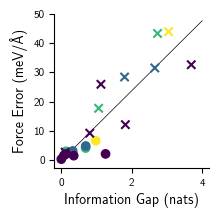

In [17]:
fig, ax = plt.subplots(figsize=(2, 2))

sc = ax.scatter(mols["gap_1000"], mols["error_1000"], c=mols["rotbonds"], marker="o")
sc = ax.scatter(mols["gap_50"], mols["error_50"], c=mols["rotbonds"], marker="x")

xlim = np.array([0, 4])
ax.plot(xlim, reg.intercept + reg.slope * xlim, "k-", zorder=-1, linewidth=0.5)

# cbar = fig.colorbar(sc)
# cbar.set_label("# Rot. Bonds")
# cbar.set_ticks([0, 1, 2, 3])

ax.set_ylabel("Force Error (meV/Å)")
ax.set_xlabel("Information Gap (nats)")

# savefig(fig, "04-rmd17-gap.pdf")
plt.show()

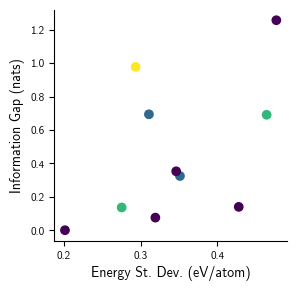

In [18]:
fig, ax = plt.subplots(figsize=(3, 3))

sc = ax.scatter(mols["estd"], mols["gap_1000"], c=mols["rotbonds"])

# cbar = fig.colorbar(sc)
# cbar.set_label("# Rot. Bonds")
# cbar.set_ticks([0, 1, 2, 3])

ax.set_ylabel("Information Gap (nats)")
ax.set_xlabel("Energy St. Dev. (eV/atom)")

# savefig(fig, "04-rmd17-energy-std-gap.pdf")
plt.show()

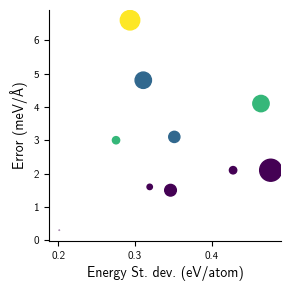

In [19]:
fig, ax = plt.subplots(figsize=(3, 3))

sc = ax.scatter(mols["estd"], mols["error_1000"], s=mols["gap_1000"] * 200 , c=mols["rotbonds"])

# cbar = fig.colorbar(sc)
# cbar.set_label("# Rot. Bonds")
# cbar.set_ticks([0, 1, 2, 3])

ax.set_ylabel("Error (meV/Å)")
ax.set_xlabel("Energy St. dev. (eV/atom)")

# savefig(fig, "04-rmd17-energy-std.pdf")
plt.show()

## Plotting the energy distributions

In [20]:
DATA_PATH = "../data/02-rMD17/energies"
files = sorted(os.listdir(DATA_PATH))

energies = {}
for _file in files:
    name = _file.split(".")[0]
    path = os.path.join(DATA_PATH, _file)

    with open(path, "r") as f:
        e = np.array([
            float(line)
            for line in f.readlines()
        ])

    energies[name] = e - e.min()

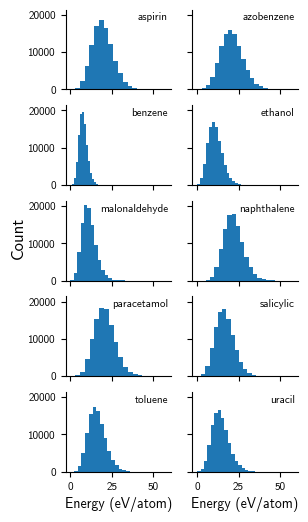

In [21]:
fig, axs = plt.subplots(5, 2, figsize=(3, 6), sharex=True, sharey=True)

for ax, (k, e) in zip(axs.ravel(), energies.items()):
    ax.hist(e, bins=20)
    ax.annotate(k, (0.97, 0.97), xycoords="axes fraction", va="top", ha="right", fontsize=8)

for ax in axs[-1, :]:
    ax.set_xlabel("Energy (eV/atom)")

fig.supylabel("Count", x = -0.06)
# savefig(fig, "04-rmd17-energy-hist.pdf")
plt.show()